# Performing the Higgs -> ZZ -> 4 leptons search 





<a id='contents'></a>

<a id='running'></a>

# Installation of packages not available by default on colab


In [1]:
import sys
# update the pip package installer
#%pip install --upgrade --user pip
# install required packages
#%pip install --upgrade --user uproot awkward vector numpy matplotlib

#!pip install uproot
#!pip install vector
#!pip install awkward
#!pip install hist

## Import packages used in the analysis

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us store data as awkward arrays, a format that generalizes numpy to nested data with possibly variable length lists
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [2]:
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd


## Data fraction, file path

General definitions of fraction of data used, where to access the input files

In [3]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
fraction = 1 # reduce this is if you want the code to run quicker

<a id='fraction'></a>

In [4]:
fraction = 1. # reduce this is if you want the code to run quicker
                                                                                                                                  
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

Units, as stored in the data files.<br /> 
The quantities in the ATLAS ntuple are unfortunately stored in MeV.<br />
Since the natural unit for LHC analysis is GeV, we define conversion factors

In [5]:
MeV = 0.001
GeV = 1.0
mz = 91.12

Define different classes of ntuples to access as a dictionary called "samples".<br />
One has four types of ntuples:<br />
<ul>
<li>Data: the real data collected by ATLAS at the LHC
<li>Reducible backgrounds: 
<li>Irreducible backgrounds
<li>Signal
</ul>
The names in the list must correspond to the names of a sample defined in infofile.py

In [6]:
samples = {
  'data': {
    'list' : ['data_A','data_B','data_C','data_D'],
  },
  'reducible' : { # Z + ttbar
     'list' : ['Zee','Zmumu','ttbar_lep'],
     'color' : "#6b59d3" # purple
  },
  'irreducible' : { # ZZ
     'list' : ['llll'],
     'color' : "#ff0000" # red
  },
  'signal' : { # H -> ZZ -> llll
     'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
     'color' : "#00cdff" # light blue
  },
}

Infofile.py contains for all the MC samples made available by ATLAS the factors necessary to calculate the normalisation of the MC samples to the data
Print the first entry to show the content

In [7]:
import os.path
if os.path.isfile('infofile.py')==False:
  !wget https://raw.githubusercontent.com/atlas-outreach-data-tools/notebooks-collection-opendata/master/13-TeV-examples/uproot_python/infofile.py    
import infofile    
!head -n 12 infofile.py

"""Dict with DSID, # events, reduction efficiency, sum of weights, cross-section for each MC"""

infos = {

    # ZPrime -> ee

    'ZPrime2000_ee': {'DSID'    : 301215,
                      'events'  : 19800,
                      'red_eff' :1,
                      'sumw'    :19800,
                      'xsec'    :0.0088432},



Load into info vector contents of the file and for each sample calculate weight to apply to events when calculating statistics

In [8]:
def get_xsec_weight(sample):
  info = infofile.infos[sample] # open infofile
  xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
  return xsec_weight # return cross-section weight

def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON
        * events.scaleFactor_LepTRIGGER
    )

In [9]:
def get_data_from_files():

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Processing '+s+' samples') # print which sample
    frames = [] # define empty list to hold data
    for val in samples[s]['list']: # loop over each file
      if s == 'data': prefix = "Data/" # Data prefix
      else: # MC prefix
        prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
      fileString = tuple_path+prefix+val+".4lep.root" # file name to open
      temp = read_file(fileString,val) # call the function read_file defined below
      frames.append(temp) # append dataframe returned from read_file to list of dataframes
    data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes

  return data # return dictionary of dataframes

Define function to calculate 4-lepton invariant mass.<br />
It accesses the dataframe where the particle data are stored as scalar components, and creates an array of 4-vectors 

In [10]:
def calc_mllll(dff):
#
#   create array of 4-vectors, one for each lepton
#
    pl=[]
    pl.append(vector.array({"pt":dff["ptl1"], "phi":dff["phil1"], "eta":dff["etal1"], "e":dff["el1"]}))
    pl.append(vector.array({"pt":dff["ptl2"], "phi":dff["phil2"], "eta":dff["etal2"], "e":dff["el2"]}))
    pl.append(vector.array({"pt":dff["ptl3"], "phi":dff["phil3"], "eta":dff["etal3"], "e":dff["el3"]}))
    pl.append(vector.array({"pt":dff["ptl4"], "phi":dff["phil4"], "eta":dff["etal4"], "e":dff["el4"]}))
    return (pl[0]+pl[1]+pl[2]+pl[3]).M

In [11]:
# Loop  based calculation of invariant mass of leading lepton pair
#
def calc_mll12(dff):
#
#   create array of 4-vectors, one for each lepton
#
    pl=[]
    chl=[dff["chl1"],dff["chl2"],dff["chl3"],dff["chl4"]]
    typl=[dff["typl1"],dff["typl2"],dff["typl3"],dff["typl4"]]
    pl.append(vector.array({"pt":dff["ptl1"], "phi":dff["phil1"], "eta":dff["etal1"], "e":dff["el1"]}))
    pl.append(vector.array({"pt":dff["ptl2"], "phi":dff["phil2"], "eta":dff["etal2"], "e":dff["el2"]}))
    pl.append(vector.array({"pt":dff["ptl3"], "phi":dff["phil3"], "eta":dff["etal3"], "e":dff["el3"]}))
    pl.append(vector.array({"pt":dff["ptl4"], "phi":dff["phil4"], "eta":dff["etal4"], "e":dff["el4"]}))
    ptl1=dff["ptl1"]
    print(ptl1.size)
    m12=[]
    for k in range(0,ptl1.size):
      im=-1
      jm=-1
      diffmin=999999
      for i in range(0,4) :
        for j in range(i+1,4):
          isossf=(((chl[i]*typl[i]+chl[j]*typl[j]))[k]==0)
          if isossf:
            m12t=((pl[i]+pl[j])[k]).M
            diff=abs(mz/MeV-m12t)
            if diff<diffmin:
              im=i
              jm=j    
              m12m=m12t
      m12.append(m12m)
    return m12



In [12]:
#   given two integers between zero and 4
#   return the two complementary integers in the same range
#   as a 2-dim array
def comp_ind(i,j):
  aa=np.zeros(4)
  ind=[i,j]
  aa[ind]=1
  bb=np.where(aa == 0)[0]
  return bb

# find the pairing of opposite-sign same-flavour leptons 
# with invariant mass nearest to the Z mass, and 
# return their invariant mass as m12, as well as the 
# invariant mass for the complementary lepton-lepton pair
# implementation using the power of numpy
def calc_mll12v(dff):
#
#   create array of 4-vectors, one for each lepton
#
  pl=[]
  chl=[dff["chl1"],dff["chl2"],dff["chl3"],dff["chl4"]]
  typl=[dff["typl1"],dff["typl2"],dff["typl3"],dff["typl4"]]
  pl.append(vector.array({"pt":dff["ptl1"], "phi":dff["phil1"], "eta":dff["etal1"], "e":dff["el1"]}))
  pl.append(vector.array({"pt":dff["ptl2"], "phi":dff["phil2"], "eta":dff["etal2"], "e":dff["el2"]}))
  pl.append(vector.array({"pt":dff["ptl3"], "phi":dff["phil3"], "eta":dff["etal3"], "e":dff["el3"]}))
  pl.append(vector.array({"pt":dff["ptl4"], "phi":dff["phil4"], "eta":dff["etal4"], "e":dff["el4"]}))
# get number of events and create nupmy vectors for
# to be filled with final variable
  siz=dff["ptl1"].size
  m12m=np.full(siz,99999999.)
  m34m=np.full(siz,99999999.)
  diffm=np.full(siz,999999999.)
#
# loop over all lepton-lepton pairings among 4 leptons in ev  for i in range(0,4) :
  for i in range(0,4) :
    for j in range(i+1,4):
# isossf is equal zero if the two leptons are same flavour opposite sign (OSSF)
# a positive integer number otherwise
      isossf=abs(chl[i]*typl[i]+chl[j]*typl[j])
# set a factor 1 for OSSF an 1e10 otherwise
      bossf=np.where(isossf < 0.5, 1, 1e10)
# calculate invariant  mass 
      m12t=(pl[i]+pl[j]).M
# get indexes of two complementary leptons
      bb=comp_ind(i,j)
# calulate their invariant mass
      m34t=(pl[bb[0]]+pl[bb[1]]).M
# absolute value of difference with mZ
# if lepton pair is not OSSF it is a very large number
      difft=abs(m12t-mz/MeV)*bossf
# if abs difference is smaller than the one from the
# previous pairings, overwrite the invariant masses and
# update the difference
      m12m=np.where(difft<diffm,m12t,m12m)
      m34m=np.where(difft<diffm,m34t,m34m)
      diffm=np.where(difft<diffm,difft,diffm)
# return masses
  return m12m, m34m


Simple template for a selection function acting on the dataframe, it creates a boolean

In [ ]:
def cut_ptl1(df):
#
    return (df.ptl1>5/MeV)
def cut_ptl2(df):
#
    return (df.ptl2>20/MeV)

In [13]:
def cut_iso(df):
   isol1=(df["ptcl1"]/df["ptl1"]<0.2) & (df["etcl1"]/df["ptl1"]<0.2)
   isol2=(df["ptcl2"]/df["ptl2"]<0.2) & (df["etcl2"]/df["ptl2"]<0.2)
   isol3=(df["ptcl3"]/df["ptl3"]<0.2) & (df["etcl3"]/df["ptl3"]<0.2)
   isol4=(df["ptcl4"]/df["ptl4"]<0.2) & (df["etcl4"]/df["ptl4"]<0.2)
   return isol1 & isol2 & isol3 & isol4
def cut_2ossf(df):
   ltc1=df["chl1"]*df["typl1"]
   ltc2=df["chl2"]*df["typl2"]
   ltc3=df["chl3"]*df["typl3"]
   ltc4=df["chl4"]*df["typl4"]
   return ltc1+ltc2+ltc3+ltc4==0
def cut_tight(df):
   return (df["tightl1"]==1) & (df["tightl2"]==1)  & (df["tightl3"]==1) & (df["tightl4"]==1)

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event

In [14]:
def read_file(path, sample):
  with uproot.open( path + ":mini") as tree:
    numevents = tree.num_entries # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
# variables to extract from ntuple
    lepvar=["lep_pt", "lep_eta", "lep_phi","lep_E",
          "lep_charge","lep_type",
          "lep_ptcone30","lep_etcone20", "lep_isTightID"]
    lepwei=[MeV,1.,1.,MeV,
            1.,1.]
    weivar=["mcWeight","scaleFactor_PILEUP",
            "scaleFactor_ELE","scaleFactor_MUON",
            "scaleFactor_LepTRIGGER"] # variables to calculate Monte Carlo weight

    tupvar=weivar+lepvar
# read tree into awkward array with uproot
    lep_momentum = tree.arrays(tupvar,entry_stop=numevents*fraction,library="ak")
# define the names of the variables to go into dataframe
    colnam=["ptl1","etal1","phil1","el1","chl1","typl1","ptcl1","etcl1","tightl1",
          "ptl2","etal2","phil2","el2","chl2","typl2","ptcl2","etcl2","tightl2",
          "ptl3","etal3","phil3","el3","chl3","typl3","ptcl3","etcl3","tightl3",
          "ptl4","etal4","phil4","el4","chl4","typl4","ptcl4","etcl4","tightl4"]
# create numpy vector assuming that lep_ arrays have 4 components
    for i in range(0,4):
      for j in range(0,len(lepvar)):
        if i==0 and j==0:
          ptlep=ak.to_numpy(lep_momentum[lepvar[j]][:,i])
        else:
          ptlep=np.vstack([ptlep,ak.to_numpy(lep_momentum[lepvar[j]][:,i])])
    print(ptlep.shape)
# end up with numpy 2d vector with n_var rows and n_event columns
# to transpose, as in pandas 'features' are columns and 'observations' rows
    ptlep=ptlep.transpose()
# create dataframe 
    df = pd.DataFrame(ptlep)
# add names of columns
    df.columns=colnam    
    if 'data' not in sample: # only do this for Monte Carlo simulation files
# multiply all Monte Carlo weights and scale factors together to give total weight
      df["totalWeight"] = calc_weight(xsec_weight, lep_momentum)    
# add new derived variable
    df["mllll"]=calc_mllll(df)
#    df["mll12"]=calc_mll12(df)
    
# apply cuts on variable
    df=df[cut_ptl1(df)]
    return df

This is where the processing happens

In [15]:
start = time.time() # time at start of whole processing
df = get_data_from_files() #process all files
print(df.keys())
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
(36, 39)
(36, 156)
(36, 237)
(36, 400)
Processing reducible samples
(36, 898)
(36, 684)
(36, 1031)
Processing irreducible samples
(36, 554279)
Processing signal samples
(36, 164716)
(36, 191126)
(36, 15379)
(36, 14485)
dict_keys(['data', 'reducible', 'irreducible', 'signal'])
Time taken: 102.2s


Define routine which loops over all the samples in the dictionary of dataframes and applies
selections on them. <br />
It would be simpler to aplly the cuts when reading the files, but in this way you can play with 
the selections without the need of reloading the files every time<br />
One can also create dataframes with different selection levels and compare them

In [16]:
def apply_selections(df):

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Apply selections on '+s+' samples') # print which sample
    print('before', df[s].shape) 
    seldf=df[s]
    seldf=seldf[cut_iso(df[s])]
    seldf=seldf[cut_tight(seldf)]
    seldf=seldf[cut_2ossf(seldf)]
    print('after',seldf.shape)
    data[s]=seldf
#    data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes

  return data # return dictionary of dataframes

In [17]:
def add_columns(df):

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Add columns '+s+' samples') # print which sample
    print('before', df[s].shape) 
    adddf=df[s] 
    m12,m34=calc_mll12v(adddf)
 #   print(abs(m12/1000-91.12)[0]-abs(m34/1000-91.12)[0])
    
    adddf["mll12"]=m12
    adddf["mll34"]=m34
    data[s]=adddf

  return data # return dictionary of dataframes

In [18]:
# Calculate events for available samples in dataframe dictionary normalised
# to available statistics
def calc_events(df):
  stat = {} # define empty dictionary to hold stat
  for s in samples: # loop over samples
    if s not in ['data']: 
      print('Calculate events on '+s+' samples') # print which sample
      stat[s]=(df[s]['totalWeight']).sum()
    if s in ['data']:
      stat[s]=df[s].shape[0]
  return stat # return dictionary of statistics

In [19]:
finstat=calc_events(df)
nsig=finstat['signal']
nbg=finstat['reducible']+finstat['irreducible']
print(nsig,nbg)

Calculate events on reducible samples
Calculate events on irreducible samples
Calculate events on signal samples
9.948183 671.64264


Now apply selection and store it in differently named dataframe

In [20]:
dfs=apply_selections(df)
df=add_columns(df)

Apply selections on data samples
before (832, 37)
after (241, 37)
Apply selections on reducible samples
before (2613, 38)
after (113, 38)
Apply selections on irreducible samples
before (554279, 38)
after (333967, 38)
Apply selections on signal samples
before (385706, 38)
after (216333, 38)
Add columns data samples
before (832, 37)
Add columns reducible samples
before (2613, 38)
Add columns irreducible samples
before (554279, 38)
Add columns signal samples
before (385706, 38)


In [21]:
finstat1=calc_events(dfs)
nsig1=finstat1['signal']
nbg1=finstat1['reducible']+finstat1['irreducible']
print(nsig1,nbg1)

Calculate events on reducible samples
Calculate events on irreducible samples
Calculate events on signal samples
5.63938 190.48286


In [22]:
from math import sqrt, log
def calc_sig(nsig, nbg, nbExpEr):
    nbObs=nsig+nbg
    nbExp=nbg
    if nbExp>0 and nbExpEr>0:
      factor1 = nbObs*log( (nbObs*(nbExp+nbExpEr**2))/(nbExp**2+nbObs*nbExpEr**2) )
      factor2 = (nbExp**2/nbExpEr**2)*log( 1 + (nbExpEr**2*(nbObs-nbExp))/(nbExp*(nbExp+nbExpEr**2)) )
      signi  = sqrt(2*(factor1 - factor2))
    if nbExp>0 and nbExpEr==0:
      signi=sqrt(2*((nsig+nbg)*log(1+nsig/nbg)-nsig))
    if nbExp==0 and nbExpEr==0:
      signi=sqrt(nsig)
    if nbExp==0 and nbExpEr>0:
      signi=nsig/sqrt(nbExpEr)
    return signi

In [23]:
print("significance is ",calc_sig(nsig1,nbg1,0.))

significance is  0.4066124045321231


## Plotting

Set simple wrapper for plotting histograms with matplotlib

In [24]:
# in input:  df=dataframe var=variable in dataframe, 
# scale=scale factor on value of variable (e.g. for scaling between MeV and GeV)
# nbin,xlow,xhigh: limits of histogram
# norm: choose whether you plot acutal number of events in bin or fraction of events 
#       in each bin with respect to total
# labx, laby labels of x and y axis of histogram 
# title: title of hisotgram
# leg: legenda for content, useful if you superimpose two hists
def hist1d(df, var, scale, nbin, xlow, xhig, norm, labx, laby, title, leg):
  bins = np.linspace(xlow,xhig,nbin)
  plt.hist(df[var]*scale, bins, alpha=0.5, density=norm, label=leg)
  plt.xlabel(labx)
  plt.ylabel(laby)
  plt.legend(loc='best')
# 2d, same definition of inputs as above
def hist2d(df,var1,var2,scalex,scaley,nbinx,xlow,xhig,nbiny,ylow,yhig,labx,laby,title):
  binx = np.linspace(xlow,xhig,nbinx)
  biny = np.linspace(ylow,yhig,nbiny)
  plt.hist2d(df[var1]*scalex, df[var2]*scaley, bins=[binx, biny], density=False, cmin=0.5)
  plt.xlabel(labx)
  plt.ylabel(laby)

Examples of plotting a couple of basic variables for inspection

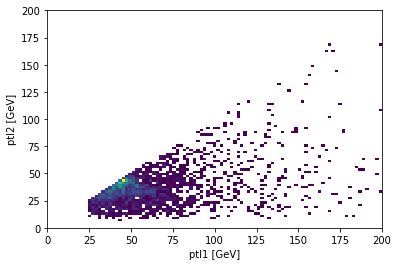

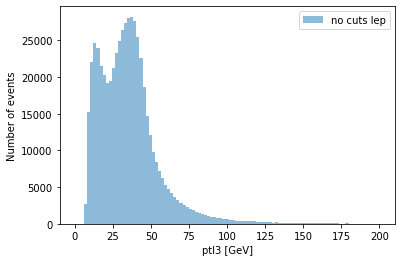

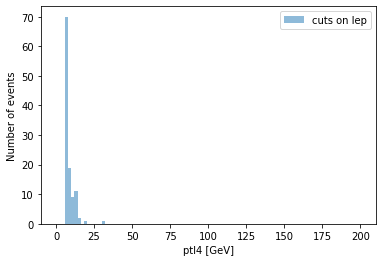

In [29]:
hist2d(df['reducible'],"ptl1","ptl2",MeV,MeV,100,0.,200.,100,0.,200.,'ptl1 [GeV]','ptl2 [GeV]','')
plt.show()
hist1d(df['irreducible'],"ptl3",MeV,100,0.,200.,False,'ptl3 [GeV]','Number of events','','no cuts lep')
plt.show()
hist1d(dfs['reducible'],"ptl4",MeV,100,0.,200.,False,'ptl4 [GeV]','Number of events','','cuts on lep')
plt.show()

## Producing ATLAS  publication plots

Plot the distribution of the invariant mass of 4 leptons for backgrounds, data, and signals based on the graphical style of ATLAS<br />
Backgrounds and signal are stacked, to provide direct comparison with data.<br /> 
Slightly adapted from the original ATLAS notebook

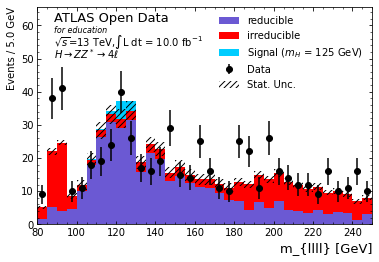

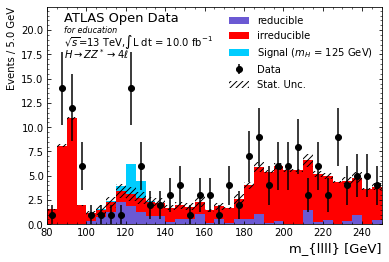

In [26]:
from matplotlib.ticker import AutoMinorLocator # for minor ticks
def plot_data(data, var, scale, xmin, xmax, step_size, labx):
  
#  xmin = 0.*GeV
#  xmax = 200.*GeV
#  step_size = 5.*GeV
#  scale=0.001
  bin_edges = np.arange(start=xmin, # The interval includes this value
                   stop=xmax+step_size, # The interval doesn't include this value
                   step=step_size ) # Spacing between values
  bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                          stop=xmax+step_size/2, # The interval doesn't include this value
                          step=step_size ) # Spacing between values

  data_x,_ = np.histogram((data['data'][var])*scale,
                          bins=bin_edges ) # histogram the data
  data_x_errors = np.sqrt( data_x ) # statistical error on the data

  signal_x = (data['signal'][var])*scale # histogram the signal
  signal_weights = data['signal']["totalWeight"] # get the weights of the signal events
  signal_color = samples['signal']['color'] # get the colour for the signal bar

  mc_x = [] # define list to hold the Monte Carlo histogram entries
  mc_weights = [] # define list to hold the Monte Carlo weights
  mc_colors = [] # define list to hold the colors of the Monte Carlo bars
  mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

  for s in samples: # loop over samples
      if s not in ['data', 'signal']: # if not data nor signal
          mc_x.append((data[s][var])*scale) # append to the list of Monte Carlo histogram entries
          mc_weights.append(data[s]["totalWeight"]) # append to the list of Monte Carlo weig 
          mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
          mc_labels.append( s ) # append to the list of Monte Carlo legend labels

  # *************
  # Main plot
  # *************
  main_axes = plt.gca() # get current axes

  # plot the data points
  main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                     fmt='ko', # 'k' means black and 'o' is for circles
                     label='Data')

  # plot the Monte Carlo bars
  mc_heights = main_axes.hist(mc_x, bins=bin_edges,
                              weights=mc_weights, stacked=True,
                              color=mc_colors, label=mc_labels )

  
  mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
  # calculate MC statistical uncertainty: sqrt(sum w^2)
  mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

  # plot the signal bar
  main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot,
                 weights=signal_weights, color=signal_color,
                 label=r'Signal ($m_H$ = 125 GeV)')

  # plot the statistical uncertainty
  main_axes.bar(bin_centres, # x
                2*mc_x_err, # heights
                alpha=0.5, # half transparency
                bottom=mc_x_tot-mc_x_err, color='none',
                hatch="////", width=step_size, label='Stat. Unc.' )

  # set the x-limit of the main axes
  main_axes.set_xlim( left=xmin, right=xmax )

  # separation of x axis minor ticks
  main_axes.xaxis.set_minor_locator( AutoMinorLocator() )

  # set the axis tick parameters for the main axes
  main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

  # x-axis label
  main_axes.set_xlabel(labx,
                      fontsize=13, x=1, horizontalalignment='right' )

  # write y-axis label for main axes
  main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                       y=1, horizontalalignment='right')

  # set y-axis limits for main axes
  main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

  # add minor ticks on y-axis for main axes
  main_axes.yaxis.set_minor_locator( AutoMinorLocator() )

  # Add text 'ATLAS Open Data' on plot

  plt.text(0.05, # x
           0.93, # y
           'ATLAS Open Data', # text
           transform=main_axes.transAxes, # coordinate system used is that of main_axes
           fontsize=13 )

  # Add text 'for education' on plot
  plt.text(0.05, # x
           0.88, # y
           'for education', # text
           transform=main_axes.transAxes, # coordinate system used is that of main_axes
           style='italic',
           fontsize=8 )

  # Add energy and luminosity
  lumi_used = str(lumi*fraction) # luminosity to write on the plot
  plt.text(0.05, # x
           0.82, # y
           '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
           transform=main_axes.transAxes ) # coordinate system used is that of main_axes

  # Add a label for the analysis carried out
  plt.text(0.05, # x
           0.76, # y           
           r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text
           transform=main_axes.transAxes ) # coordinate system used is that of main_axes

  # draw the legend
  main_axes.legend( frameon=False ) # no box around the legend
  plt.show()
  return
plot_data(df,'mllll',MeV,80.,250.,5., r'm_{llll} [GeV]')
plot_data(dfs,'mllll',MeV,80.,250.,5., r'm_{llll} [GeV]')





## Exercises

* Add more cuts from the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0040) trying to get to a version of Figure 2 of the paper similar to the published one (hint: concentrate on the lepton id cuts)
* Calculate the efficiency of the cuts on the various data classes
* Get the estimated numbers of events, like [Table 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#tl0030)
* Calculate the mass of the leading and subleading lepton pair according to the definition of the paper
   * Looping on events (relatively easy)
   * Using the vector algebra of numpy
* Add a plot to show the invariant mass distribution of the sub-leading lepton pair, like [Figure 1 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0010)
* Add a plot of m12 against m34, like [Figure 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0030)
* Your idea!

In [27]:
#simple_plot(df['data'])

[Back to contents](#contents)

<a id='going_further'></a>

[Back to contents](#contents)